<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Seminar-plan" data-toc-modified-id="Seminar-plan-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Seminar plan</a></span></li><li><span><a href="#Task" data-toc-modified-id="Task-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Task</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Goal" data-toc-modified-id="Goal-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Goal</a></span></li></ul></li><li><span><a href="#Model-with-many-variables" data-toc-modified-id="Model-with-many-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model with many variables</a></span></li><li><span><a href="#Model-selection" data-toc-modified-id="Model-selection-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model selection</a></span></li><li><span><a href="#Feature-selection" data-toc-modified-id="Feature-selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature selection</a></span><ul class="toc-item"><li><span><a href="#Filter-methods" data-toc-modified-id="Filter-methods-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Filter methods</a></span></li><li><span><a href="#Wrapper-methods" data-toc-modified-id="Wrapper-methods-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Wrapper methods</a></span></li><li><span><a href="#Selecting-more-than-one-feature" data-toc-modified-id="Selecting-more-than-one-feature-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Selecting more than one feature</a></span></li></ul></li><li><span><a href="#Clustering:-bird-eye-look-on-your-data" data-toc-modified-id="Clustering:-bird-eye-look-on-your-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Clustering: bird-eye look on your data</a></span><ul class="toc-item"><li><span><a href="#Textbook-example" data-toc-modified-id="Textbook-example-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Textbook example</a></span></li><li><span><a href="#Not-so-textbook-example" data-toc-modified-id="Not-so-textbook-example-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Not-so-textbook example</a></span></li></ul></li></ul></div>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

sns.set_palette('muted')
sns.set_color_codes('muted')
sns.set_style('white')
pio.templates.default = "plotly_white"

In [ ]:
%config InlineBackend.figure_format = 'retina'

# Seminar plan
- feature selection methods
- looking at data using feature extraction methods

# Task

Source: https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand#

## Data

Hourly bike rentals in Seoul for 2 years

## Goal

Predict hourly bike rentals for 1 day ahead

In [ ]:
df = pd.read_csv('../data/SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'])
df['Datetime'] = df.Date + pd.to_timedelta(df.Hour, unit='hours')
df.sample(5)

In [ ]:
data_start = pd.to_datetime('2017-12-13')

def shifted_features(data, feature_list, shift_direction, modifier_name):
    result = data.sort_values('Date')
    for feature in feature_list:
        result[f'{modifier_name} {feature}'] = result[feature].shift(shift_direction)
    return result

def diffed_features(data, feature_list, shift_direction, modifier_name, mode='absolute'):
    result = data.sort_values('Date')
    if mode == 'absolute':
        for feature in feature_list:
            result[f'{modifier_name} {feature}'] = result[feature] - result[feature].shift(shift_direction)
    if mode == 'relative':
        for feature in feature_list:
            result[f'{modifier_name} {feature}'] = result[feature] / result[feature].shift(shift_direction).clip(lower=.5)
    return result

features = df\
    .groupby('Hour')\
    .apply(shifted_features, feature_list=['Rented Bike Count', 'Seasons', 'Holiday', 'Functioning Day'],
           shift_direction=-1, modifier_name='Target')\
    .reset_index(drop=True)\
    .groupby('Hour')\
    .apply(shifted_features, feature_list=['Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 'Rainfall(mm)', 'Snowfall (cm)'], shift_direction=1,
           modifier_name='Yesterday')\
    .reset_index(drop=True)\
    .groupby('Hour')\
    .apply(shifted_features, feature_list=['Rented Bike Count', 'Seasons', 'Holiday', 'Functioning Day', 'Temperature(°C)', 'Humidity(%)', 'Rainfall(mm)', 'Snowfall (cm)'],
           shift_direction=6, modifier_name='Week before target')\
    .reset_index(drop=True)\
        .groupby('Hour')\
        .apply(diffed_features, feature_list=['Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 'Rainfall(mm)', 'Snowfall (cm)'], shift_direction=1,
               modifier_name='Yesterday-Today Abs Diff in', mode='absolute')\
        .reset_index(drop=True)\
        .groupby('Hour')\
        .apply(diffed_features, feature_list=['Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 'Rainfall(mm)', 'Snowfall (cm)'], shift_direction=1,
               modifier_name='Yesterday-Today Rel Diff in', mode='relative')\
        .reset_index(drop=True)\
        .pipe(lambda f: pd.concat([
    f.sort_values('Datetime'),
    f.sort_values('Datetime')[['Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
                               'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
                               'Rainfall(mm)', 'Snowfall (cm)', 'Datetime'
                               ]].rolling('1D', on='Datetime').min().rename(columns=lambda fname: f'Min Daily {fname}'),
    f.sort_values('Datetime')[['Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
                               'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
                               'Rainfall(mm)', 'Snowfall (cm)', 'Datetime'
                               ]].rolling('1D', on='Datetime').max().rename(columns=lambda fname: f'Max Daily {fname}'),
    f.sort_values('Datetime')[['Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
                               'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
                               'Rainfall(mm)', 'Snowfall (cm)', 'Datetime'
                               ]].rolling('7D', on='Datetime').mean().rename(columns=lambda fname: f'Mean Weekly {fname}')
], axis='columns'))\
    .query('Date >= @data_start')\
    .sort_values(['Date', 'Hour'])\
    .dropna(axis='index', how='any')
#     .apply(lambda x: x.sort_values('Date').assign(
#     target_yesterday=lambda d: d['Rented Bike Count'].shift(1),
#     t_yesterday=lambda d: d['Temperature(°C)'].shift(1),
#     humidity_yesterday=lambda d: d['Humidity(%)'].shift(1)
# ))\
target_name = 'Target Rented Bike Count'

In [ ]:
features.columns

In [ ]:
train = features.Date < pd.to_datetime('2018-09-11')
test = features.Date >= pd.to_datetime('2018-09-11')

In [ ]:
X_train, X_test = features.loc[train, features.columns != target_name], features.loc[
    test, features.columns != target_name]
y_train, y_test = features.loc[train, target_name], features.loc[test, target_name]

# Model with many variables

In [ ]:
from sklearn.preprocessing import QuantileTransformer
rf = make_pipeline(
    ColumnTransformer([
        ('selector', 'passthrough', X_train.select_dtypes('number').columns.tolist()),
#         ('quantiletransformer', QuantileTransformer(n_quantiles=10), X_train.select_dtypes('number').columns.tolist()),
        ('onehotencoder', OneHotEncoder(handle_unknown='ignore'),
         ['Seasons', 'Holiday', 'Functioning Day', 'Target Seasons',
          'Target Holiday', 'Target Functioning Day'])
    ]),
    RandomForestRegressor(n_estimators=500, n_jobs=-1, verbose=1)
).fit(X_train, y_train)

In [ ]:
y_pred_train = rf.predict(X_train)
print('Train RMSE %.2f' % mean_squared_error(y_true=y_train, y_pred=y_pred_train, squared=False))
print('Train MAPE %.2f%%' % mean_absolute_percentage_error(y_true=y_train.clip(lower=1), y_pred=y_pred_train))

In [ ]:
y_pred_test = rf.predict(X_test)
print('Test RMSE %.2f' % mean_squared_error(y_true=y_test, y_pred=y_pred_test, squared=False))
print('Test MAPE %.2f%%' % mean_absolute_percentage_error(y_true=y_test.clip(lower=1), y_pred=y_pred_test))

# Model selection

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
rf

In [ ]:
param_grid = dict(
    randomforestregressor__max_features=[.1, .33, .5, 1],
    randomforestregressor__max_depth=[5, 10, 25, None],
    randomforestregressor__min_samples_split=[.05, .1, 5, 10, 50],
)

In [ ]:
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'],
    cv=tscv,
    return_train_score=True,
    refit=False,
    verbose=10,
    n_jobs=-1
)

In [ ]:
cv.fit(X_train, y_train)

In [ ]:
model_selection_results = pd.DataFrame(cv.cv_results_).melt(
    id_vars='params', 
    value_vars=[f'split{split}_{data_type}_{metric}' 
                for split in range(cv.cv.n_splits) 
                for data_type in ['train', 'test']
                for metric in ['neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
               ]
).assign(variable=lambda x: x.variable.str.split('_', n=2))
model_selection_results[['split', 'data_type', 'metric']] = pd.DataFrame(model_selection_results.variable.tolist())
del model_selection_results['variable']
model_selection_results['value'] = -model_selection_results.value
model_selection_results['metric'] = model_selection_results.metric.str.replace('neg_', '')
model_selection_results

In [ ]:
import json
import pprint
px.box(
    data_frame=model_selection_results\
        .query('metric == "root_mean_squared_error"')\
        .assign(params=lambda x: x.params.map(pprint.pformat)).sort_values('value'),
    x='params',
    y='value',
    color='data_type',
    hover_data=['split']
)

In [ ]:
best_params = model_selection_results\
    .query('data_type == "test" and metric == "root_mean_squared_error"')\
    .groupby(model_selection_results.params.map(json.dumps)).value.mean().idxmin()
best_params = json.loads(best_params)
best_params

In [ ]:
best_model = rf.set_params(**best_params)
best_model.fit(X_train, y_train)

In [ ]:
y_pred_train = best_model.predict(X_train)
print('Train RMSE %.2f' % mean_squared_error(y_true=y_train, y_pred=y_pred_train, squared=False))
print('Train MAPE %.2f%%' % mean_absolute_percentage_error(y_true=y_train.clip(lower=1), y_pred=y_pred_train))

In [ ]:
y_pred_test = best_model.predict(X_test)
print('Test RMSE %.2f' % mean_squared_error(y_true=y_test, y_pred=y_pred_test, squared=False))
print('Test MAPE %.2f%%' % mean_absolute_percentage_error(y_true=y_test.clip(lower=1), y_pred=y_pred_test))

# Feature selection

Options:
- filter methods -- apply a statistical measure to assign a scoring to each feature
- wrapper methods -- a predictive model is used to evaluate a combination of features and assign a score based on model performance
- embedded methods -- feature selection is a part of the model training process

## Filter methods

How to decide whether the feature is important or not?

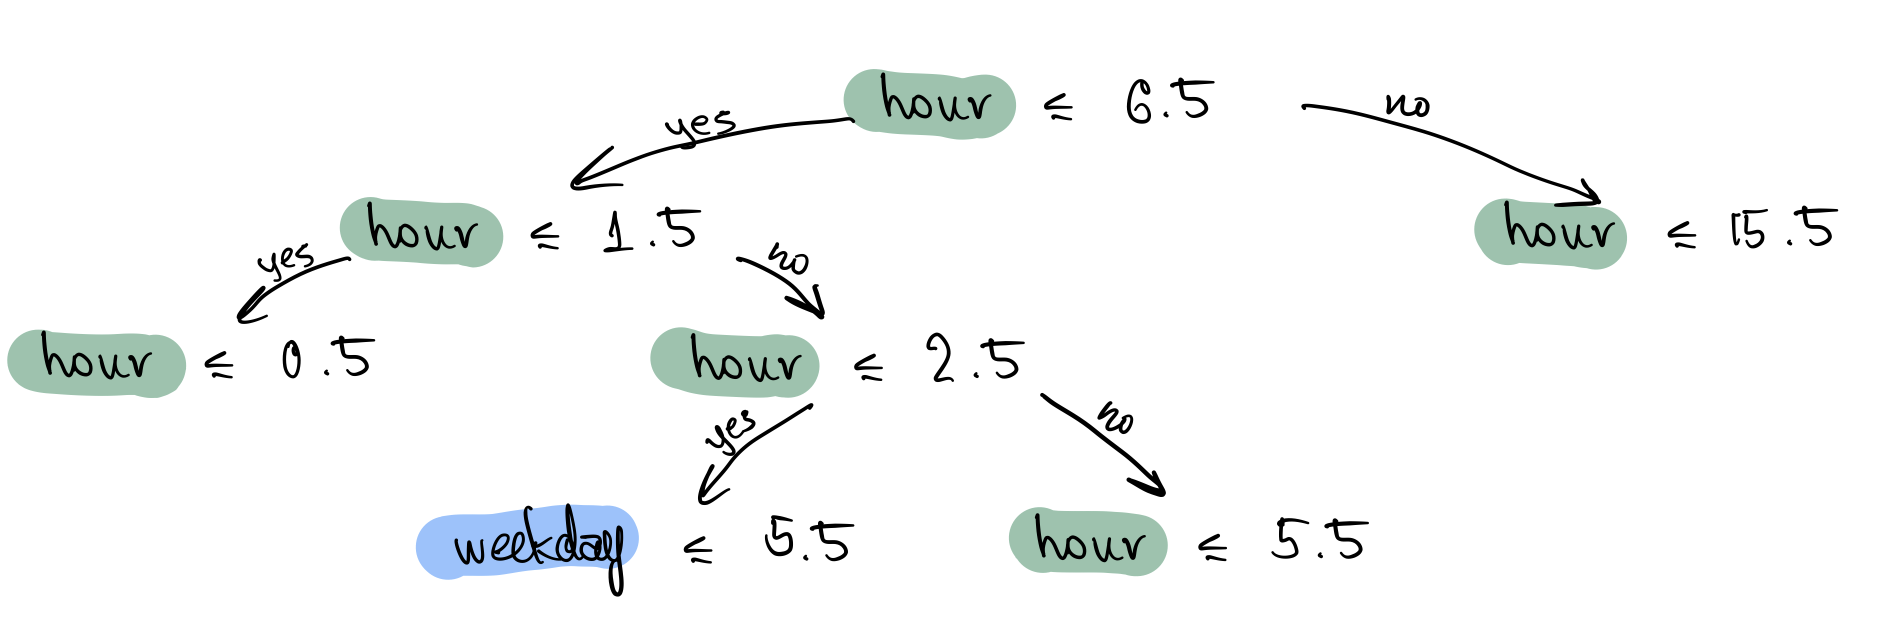

Automatically stored in `feature_importances_` property of some sklearn models

**Task**: demonstrate the feature importances of `best_model`

Naive approach: select only the first N features. What N to use?

Advanced approach: evaluate the variance of the feature importance. **Task**: implement confidence interval estimation for feature importances.

## Wrapper methods

Which features actually influence the model quality? We can know by removing these features and evaluating the model quality.

In [ ]:
train_idx = features[features.Date < pd.to_datetime('2018-06-11')].index
val_idx = features[(features.Date >= pd.to_datetime('2018-06-11')) & (features.Date < pd.to_datetime('2018-09-11'))].index

In [ ]:
best_model = rf.set_params(**best_params)
best_model.fit(X_train.loc[train_idx], y_train.loc[train_idx])

In [ ]:
from sklearn.inspection import permutation_importance
X_val_transformed = best_model.named_steps['columntransformer'].transform(X_train.loc[val_idx])
r = permutation_importance(best_model.named_steps['randomforestregressor'], X_val_transformed, y_train.loc[val_idx], n_repeats=5, scoring='neg_root_mean_squared_error')

In [ ]:
wrapper_feature_importance = pd.Series(
    r['importances_mean'],
    index=best_model.named_steps['columntransformer'].get_feature_names()
)
wrapper_feature_importance.sort_values(ascending=False).plot.bar()

***Task***: evaluate the quality of a model in which only first 10 most important features were used.

## Selecting more than one feature

Left for you =)

# Clustering: bird-eye look on your data

## Textbook example

Code from https://www.datatechnotes.com/2020/11/tsne-visualization-example-in-python.html

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
x = iris.data
y = iris.target 

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1)
z = tsne.fit_transform(x) 

In [ ]:
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

px.scatter(
    x="comp-1", 
    y="comp-2", 
    color=df.y.map(str),
    data_frame=df, 
    title="Iris data T-SNE projection") 

## Not-so-textbook example

In [ ]:
tsne = TSNE(n_components=2, verbose=1)
z = tsne.fit_transform(X_val_transformed) 
df = pd.DataFrame()
df["y"] = y_val
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

px.scatter(
    x="comp-1", 
    y="comp-2", 
    color='y',
    data_frame=df, 
    title="Seoul bike data T-SNE projection") 

More to read: https://distill.pub/2016/misread-tsne/